In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import time

In [2]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Scikit-learn and imbalanced-learn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [4]:
# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def load_and_prepare_data(path):
    """
    Load CSV, clean column names, and separate features and target.
    """
    df = pd.read_csv(path)
    df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
    df = df.drop(columns=['name'], errors='ignore')
    X = df.drop(columns=['status'])
    y = df['status']
    return X, y

In [5]:
# [1] Load data
data_path = '/content/drive/MyDrive/ML Projects/Parkinsson disease.csv'
X, y = load_and_prepare_data(data_path)

In [6]:
# [2] Train/Val/Test split (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE)

In [7]:
# [3] Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [8]:
# [4] Apply SMOTE only on training data
smote = SMOTE(sampling_strategy=0.8, random_state=RANDOM_STATE)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [9]:
# Convert back to DataFrame with original feature names
feature_names = X_train.columns.tolist()
X_train_res = pd.DataFrame(X_train_res, columns=feature_names)
X_val_df = pd.DataFrame(X_val_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

In [10]:
# [5] Correlation-based feature removal (threshold = 0.9)
corr_matrix = X_train_res.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
X_train_res = X_train_res.drop(columns=to_drop)
X_val_res = X_val_df.drop(columns=to_drop)
X_test_res = X_test_df.drop(columns=to_drop)
print(f"Dropped columns: {to_drop}")

Dropped columns: ['MDVPJitterAbs', 'MDVPRAP', 'MDVPPPQ', 'JitterDDP', 'MDVPShimmerdB', 'ShimmerAPQ3', 'ShimmerAPQ5', 'MDVPAPQ', 'ShimmerDDA', 'NHR', 'PPE']


In [11]:
# [6] Define models and hyperparameter grids
svm = SVC(probability=True, random_state=RANDOM_STATE)
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE)

param_grids = {
    'SVM': {
        'C': [1, 10, 100],
        'kernel': ['rbf'],
        'gamma': [0.001, 0.01, 0.1]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0]
    }
}

In [12]:
# [7] Hyperparameter tuning using StratifiedKFold
tuned_models = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, model, grid in [
    ('SVM', svm, param_grids['SVM']),
    ('XGBoost', xgb, param_grids['XGBoost'])
]:
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=grid,
        n_iter=10,
        cv=skf,
        scoring='f1',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    search.fit(X_train_res, y_train_res)
    tuned_models[name] = search.best_estimator_
    print(f"Best params for {name}: {search.best_params_}")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params for SVM: {'kernel': 'rbf', 'gamma': 0.1, 'C': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:34:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}


In [13]:
# [8] Evaluation function
def evaluate_model(name, model, X_df, y_true):
    start = time.time()
    y_pred = model.predict(X_df)
    y_proba = model.predict_proba(X_df)[:, 1]
    elapsed = time.time() - start

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    fpr = fp / (fp + tn)

    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_proba),
        'Specificity': specificity,
        'FPR': fpr,
        'Inference Time (s)': elapsed
    }

In [14]:
# [9] Evaluate on Validation and Test sets and 5-fold CV on training data for comparability
evaluations = []
for name, model in tuned_models.items():
    evaluations.append(evaluate_model(name, model, X_val_res, y_val))
    evaluations.append(evaluate_model(name, model, X_test_res, y_test))
# Compute cross-validated accuracy on full training set
from sklearn.model_selection import cross_val_score
for name, model in tuned_models.items():
    cv_scores = cross_val_score(model, np.vstack([X_train_res, X_val_res]),
                                np.hstack([y_train_res, y_val]),
                                cv=5, scoring='accuracy', n_jobs=-1)
    evaluations.append({
        'Model': name + ' (5-fold CV)',
        'Accuracy': cv_scores.mean(),
        'Precision': np.nan,
        'Recall': np.nan,
        'F1-Score': np.nan,
        'AUC-ROC': np.nan,
        'Specificity': np.nan,
        'FPR': np.nan,
        'Inference Time (s)': np.nan
    })

results_df = pd.DataFrame(evaluations)
print(results_df)
results_df.to_csv('svm_xgb_qpain_results.csv', index=False)
evaluations = []
for name, model in tuned_models.items():
    evaluations.append(evaluate_model(name, model, X_val_res, y_val))
    evaluations.append(evaluate_model(name, model, X_test_res, y_test))

results_df = pd.DataFrame(evaluations)
print(results_df)
results_df.to_csv('svm_xgb_qpain_results.csv', index=False)

                 Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC  \
0                  SVM  0.846154   0.870968  0.931034  0.900000  0.937931   
1                  SVM  0.923077   0.964286  0.931034  0.947368  0.965517   
2              XGBoost  0.948718   0.965517  0.965517  0.965517  0.924138   
3              XGBoost  0.923077   0.964286  0.931034  0.947368  0.948276   
4      SVM (5-fold CV)  0.929231        NaN       NaN       NaN       NaN   
5  XGBoost (5-fold CV)  0.914872        NaN       NaN       NaN       NaN   

   Specificity  FPR  Inference Time (s)  
0          0.6  0.4            0.009759  
1          0.9  0.1            0.010602  
2          0.9  0.1            0.017804  
3          0.9  0.1            0.036842  
4          NaN  NaN                 NaN  
5          NaN  NaN                 NaN  
     Model  Accuracy  Precision    Recall  F1-Score   AUC-ROC  Specificity  \
0      SVM  0.846154   0.870968  0.931034  0.900000  0.937931          0.6   
1      SVM

Confusion Matrix for SVM on Test Set:
[[ 9  1]
 [ 2 27]]


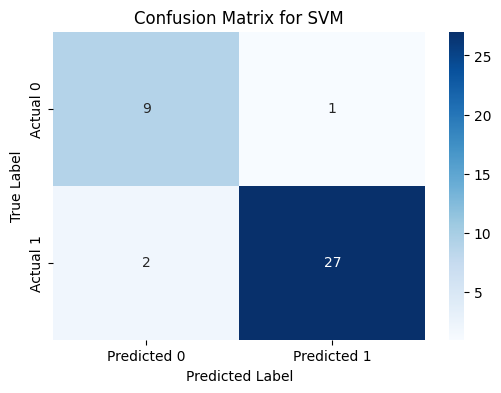

In [15]:
# Make predictions on the test set using the best SVM model
svm_best_model = tuned_models['SVM']
y_pred_svm = svm_best_model.predict(X_test_res)

# Generate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print("Confusion Matrix for SVM on Test Set:")
print(conf_matrix_svm)

# Optional: Display confusion matrix with labels
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM')
plt.show()

Confusion Matrix for XGBoost on Test Set:
[[ 9  1]
 [ 2 27]]


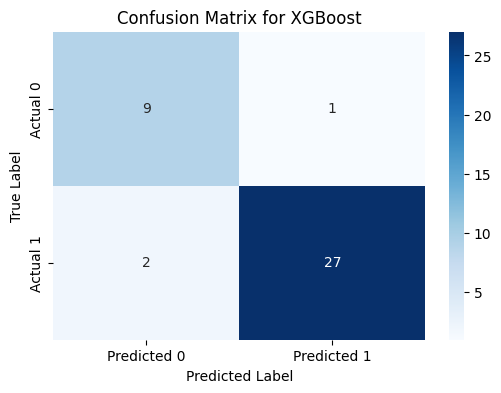

In [16]:
# Make predictions on the test set using the best XGBoost model
xgb_best_model = tuned_models['XGBoost']
y_pred_xgb = xgb_best_model.predict(X_test_res)

# Generate the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("Confusion Matrix for XGBoost on Test Set:")
print(conf_matrix_xgb)

# Optional: Display confusion matrix with labels
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost')
plt.show()

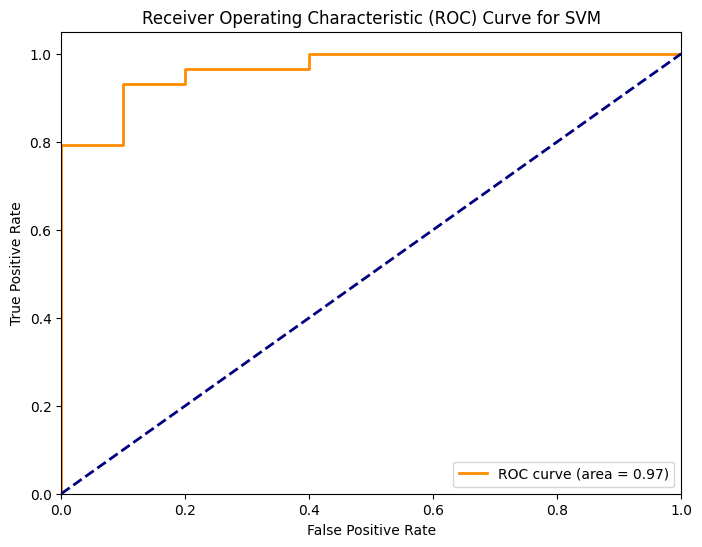

In [17]:
from sklearn.metrics import roc_curve, auc

# Make predictions on the test set using the best SVM model to get probabilities
svm_best_model = tuned_models['SVM']
y_proba_svm = svm_best_model.predict_proba(X_test_res)[:, 1]

# Calculate the ROC curve points
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_proba_svm)

# Calculate the AUC score
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVM')
plt.legend(loc="lower right")
plt.show()

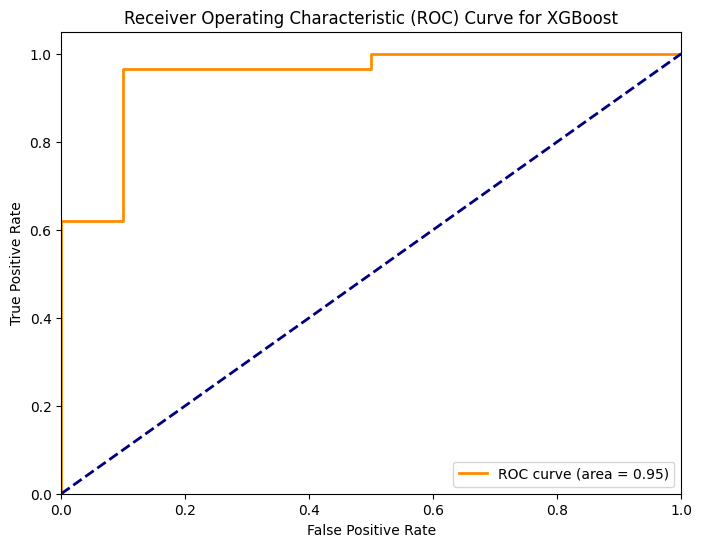

In [18]:
# Make predictions on the test set using the best XGBoost model to get probabilities
xgb_best_model = tuned_models['XGBoost']
y_proba_xgb = xgb_best_model.predict_proba(X_test_res)[:, 1]

# Calculate the ROC curve points
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)

# Calculate the AUC score
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

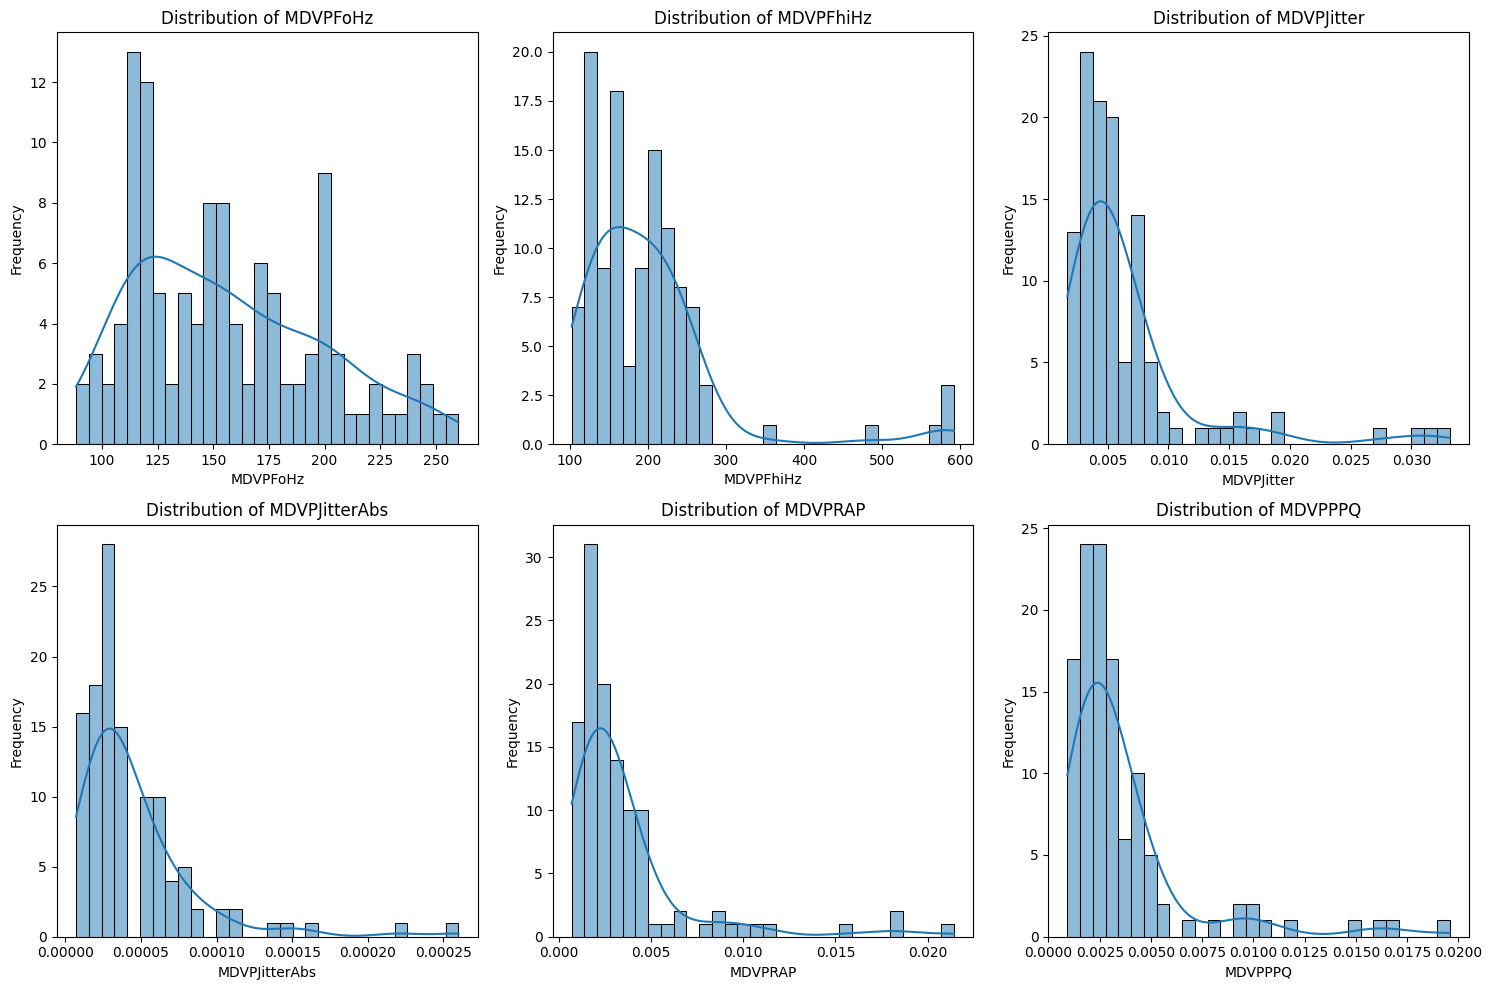

In [19]:
selected_features = ['MDVPFoHz', 'MDVPFhiHz', 'MDVPJitter', 'MDVPJitterAbs', 'MDVPRAP', 'MDVPPPQ']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_train[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Target class distribution in the original dataset:
status
1    147
0     48
Name: count, dtype: int64


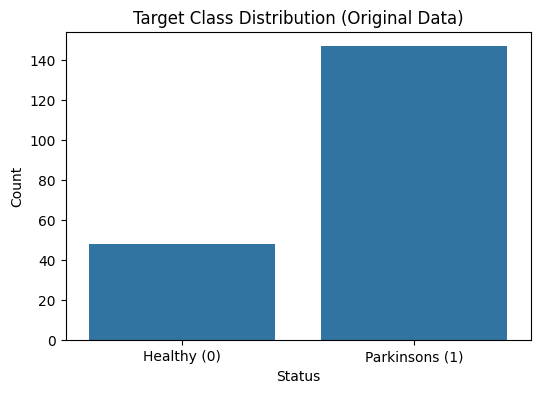


Target class distribution in the training dataset (after SMOTE):
status
1    89
0    71
Name: count, dtype: int64


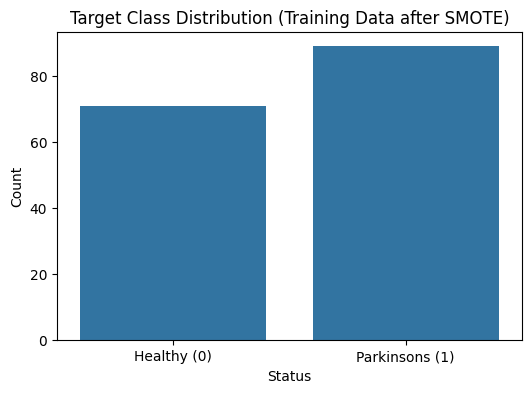

In [20]:
# Display target class distribution
print("Target class distribution in the original dataset:")
print(y.value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Target Class Distribution (Original Data)')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Healthy (0)', 'Parkinsons (1)'])
plt.show()

print("\nTarget class distribution in the training dataset (after SMOTE):")
print(y_train_res.value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_res)
plt.title('Target Class Distribution (Training Data after SMOTE)')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Healthy (0)', 'Parkinsons (1)'])
plt.show()

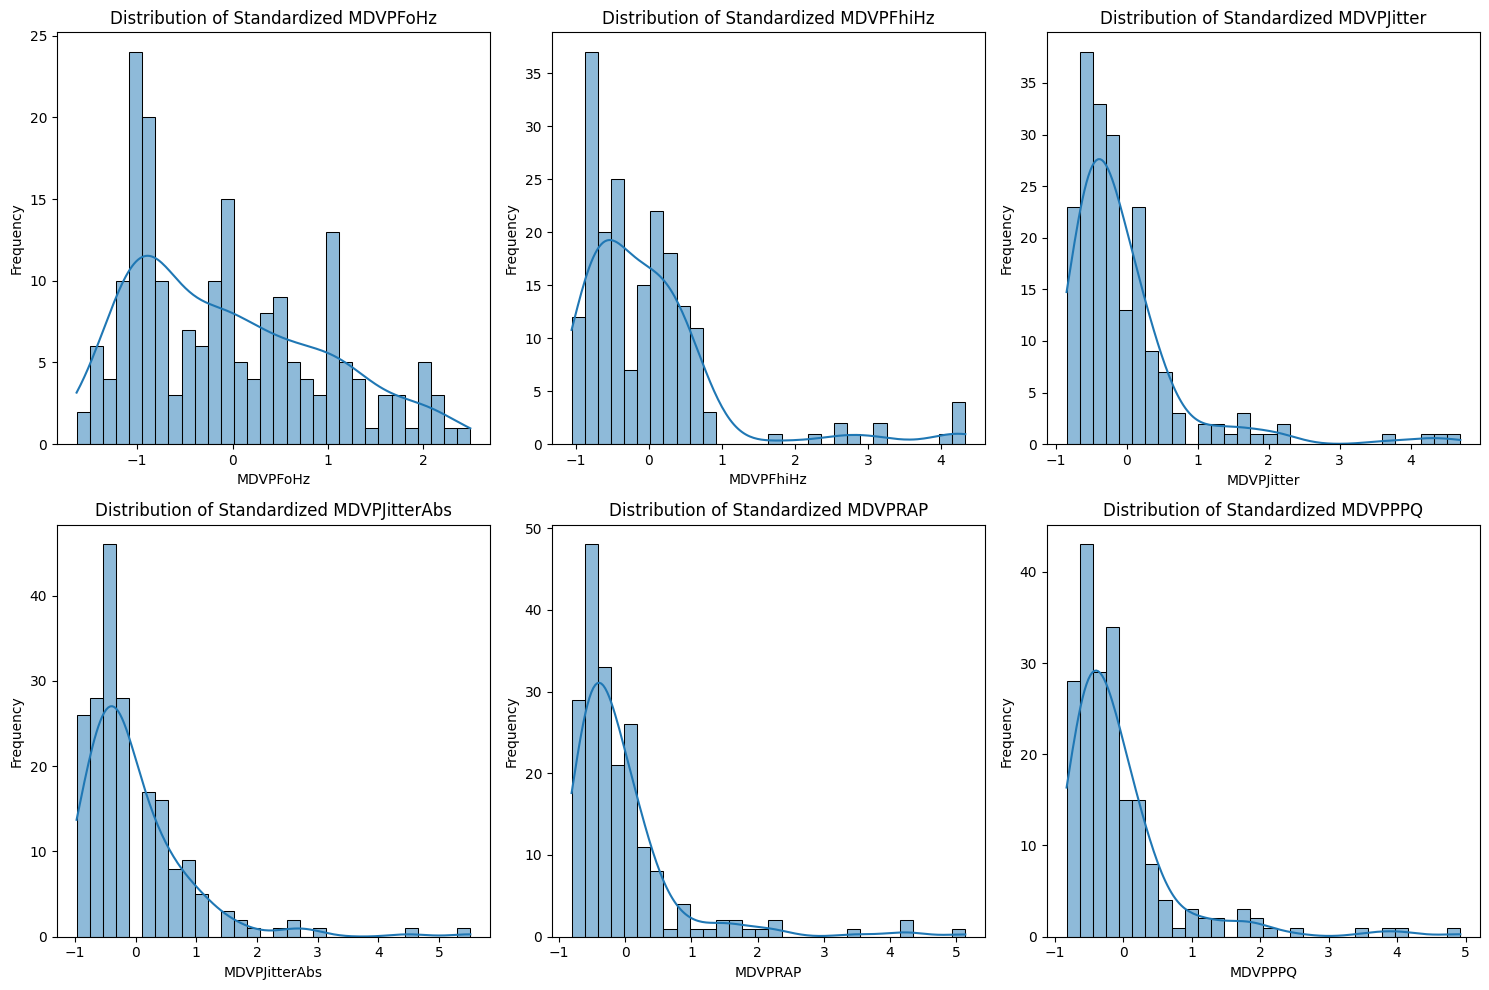

In [21]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

X_scaled_combined = pd.concat([X_train_scaled_df, X_val_scaled_df, X_test_scaled_df], axis=0)

selected_features = ['MDVPFoHz', 'MDVPFhiHz', 'MDVPJitter', 'MDVPJitterAbs', 'MDVPRAP', 'MDVPPPQ']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    if feature in X_scaled_combined.columns: # Check if feature still exists after dropping
        plt.subplot(2, 3, i + 1)
        sns.histplot(X_scaled_combined[feature], kde=True, bins=30)
        plt.title(f'Distribution of Standardized {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
    else:
        print(f"Feature '{feature}' was dropped during correlation analysis.")

plt.tight_layout()
plt.show()

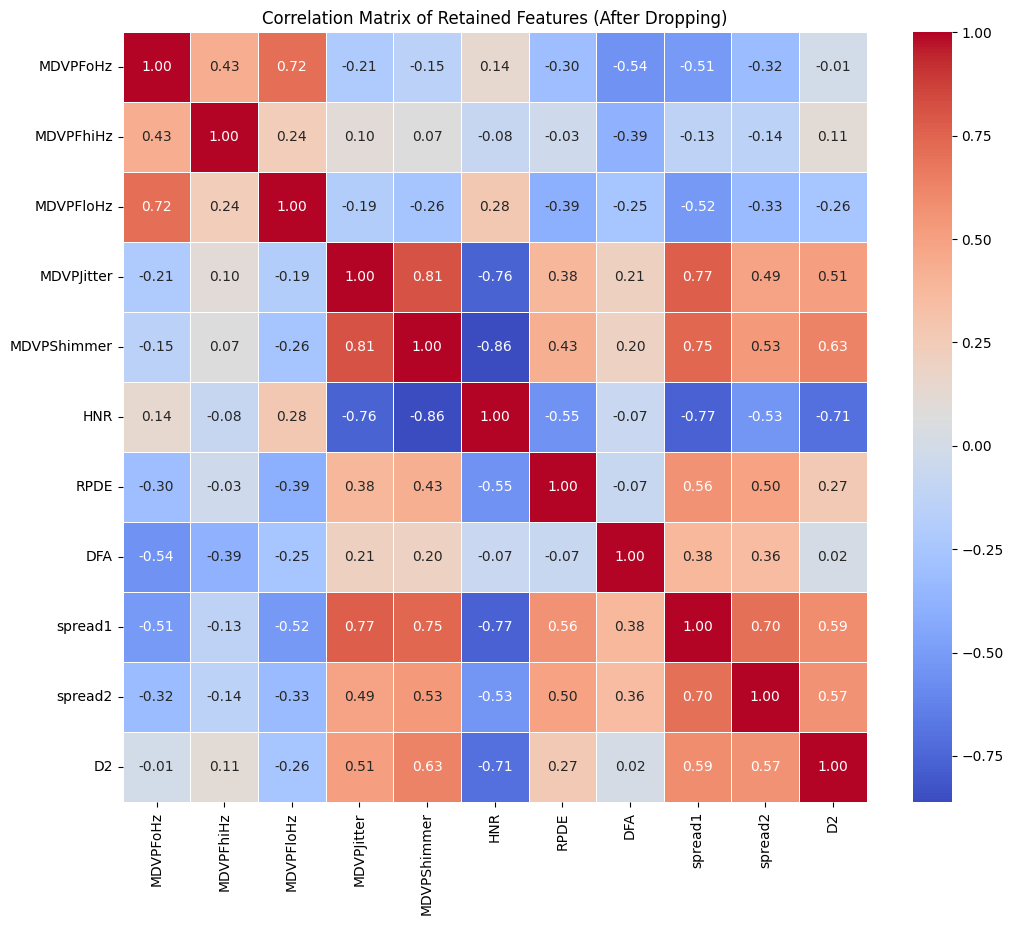

In [22]:
# Correlation heatmap of the remaining features after dropping highly correlated ones
plt.figure(figsize=(12, 10))
sns.heatmap(X_train_res.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Retained Features (After Dropping)')
plt.show()

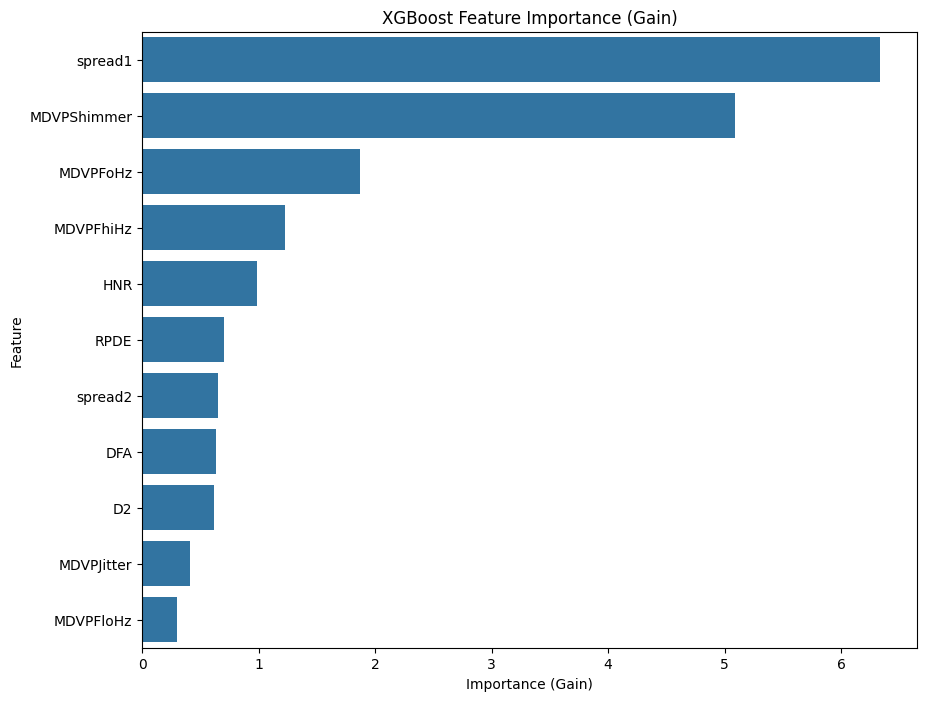


XGBoost Feature Importance (Gain):


,Feature,Gain
8,spread1,6.337247
4,MDVPShimmer,5.090749
0,MDVPFoHz,1.871493
1,MDVPFhiHz,1.223115
5,HNR,0.983466
6,RPDE,0.705453
9,spread2,0.653539
7,DFA,0.635911
10,D2,0.618364
3,MDVPJitter,0.406944


In [23]:
# Access the best XGBoost model
xgb_best_model = tuned_models['XGBoost']

# Get feature importances (Gain)
# Ensure the columns used for training the final model are used to match importances
feature_importances = xgb_best_model.get_booster().get_score(importance_type='gain')

# Convert the dictionary to a DataFrame for easier plotting
importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Gain'])

# Sort by importance and select top N features (optional, adjust N)
importance_df = importance_df.sort_values(by='Gain', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Gain', y='Feature', data=importance_df)
plt.title('XGBoost Feature Importance (Gain)')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.show()

print("\nXGBoost Feature Importance (Gain):")
importance_df


SVM Permutation Importance on Test Set:
        Feature  Mean Importance  Importance Standard Deviation
0    MDVPJitter         0.005128                       0.010256
1            D2         0.005128                       0.035897
2           HNR         0.010256                       0.034781
3     MDVPFloHz         0.025641                       0.030339
4   MDVPShimmer         0.030769                       0.019188
5     MDVPFhiHz         0.041026                       0.023500
6           DFA         0.066667                       0.030769
7          RPDE         0.076923                       0.044412
8       spread2         0.084615                       0.032535
9      MDVPFoHz         0.115385                       0.030876
10      spread1         0.164103                       0.043211


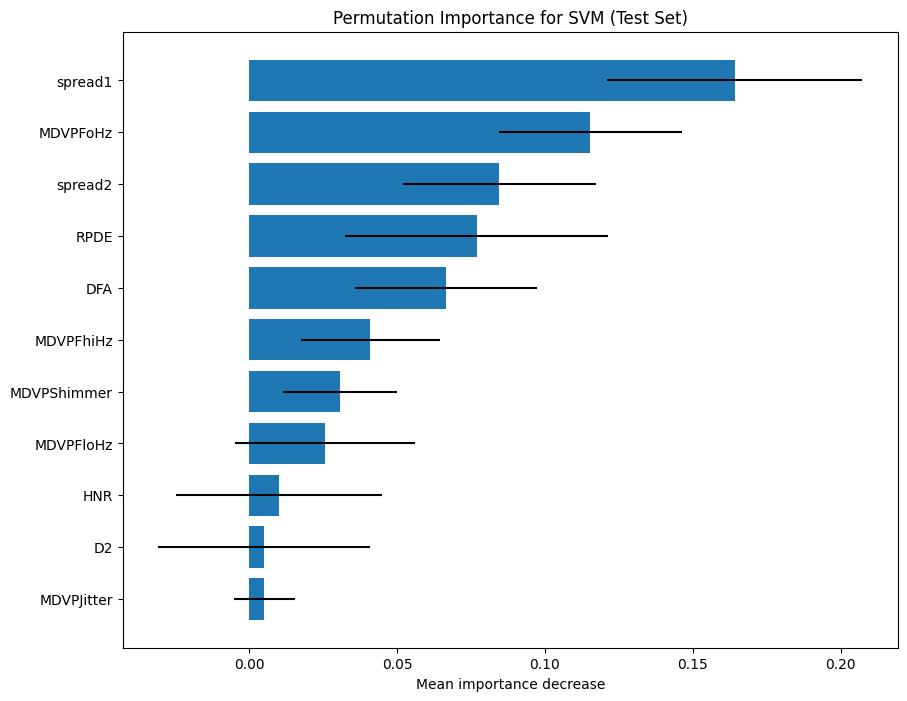

In [24]:
from sklearn.inspection import permutation_importance

# Access the best SVM model
svm_best_model = tuned_models['SVM']

# Compute Permutation Importance on the test set
result = permutation_importance(svm_best_model, X_test_res, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

# Get the feature names that were used for training the final model
feature_names_retained = X_test_res.columns

# Sort the features by importance
sorted_idx = result.importances_mean.argsort()

# Create a DataFrame for easier visualization
perm_importance_df = pd.DataFrame({
    'Feature': feature_names_retained[sorted_idx],
    'Mean Importance': result.importances_mean[sorted_idx],
    'Importance Standard Deviation': result.importances_std[sorted_idx]
})

print("\nSVM Permutation Importance on Test Set:")
print(perm_importance_df)

# Plot Permutation Importance
plt.figure(figsize=(10, 8))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Mean Importance'], xerr=perm_importance_df['Importance Standard Deviation'])
plt.xlabel("Mean importance decrease")
plt.title("Permutation Importance for SVM (Test Set)")
plt.show()

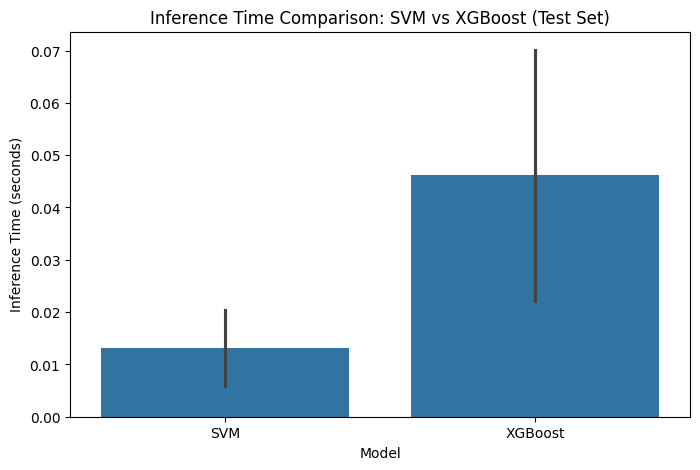

In [26]:
# Filter results to include only test set evaluations for inference time comparison
inference_results = results_df[results_df['Model'].isin(['SVM', 'XGBoost'])]

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Inference Time (s)', data=inference_results)
plt.title('Inference Time Comparison: SVM vs XGBoost (Test Set)')
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.show()